In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Block, Objective, SolverFactory, value, RangeSet, Constraint, Param
from pyomo.dae import *

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint

# -------------- JAX neural nets --------------
from jax import grad, jit, vmap
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random
# -------------- -------------- --------------

from scipy.interpolate import interp1d

# -------------- helper libraries --------------
import sys
import os
import time
import pickle

collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
# from optimization_pyomo_flexible import ODEOptimizationModel
from optimization_pyomo import ODEOptimizationModel as ODEOptimizationModel
from pickle_func import pickle_data, unpickle_data

# -------------- regular neural nets --------------
from neural_net import create_train_state, train, neural_ode

In [2]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------COLLOCATION MATRIX PREPARATION--------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

In [9]:
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

## `nn standard`

In [3]:
print(train.__doc__)


    Train the model over a specified number of epochs.
    
    Args:
        state (train_state.TrainState): Initial state of the model.
        t (jax.numpy.ndarray): Time points at which the ODE is solved.
        observed_data (jax.numpy.ndarray): True data to compare against the model's predictions.
        y0 (jax.numpy.ndarray): Initial condition for the ODE.
        num_epochs (int, optional): Number of training epochs. Default is 1000.
    
    Returns:
        train_state.TrainState: Trained model state.
    


In [53]:
layer_widths = [2, 100, 100, 2]
learning_rate = 1e-3
    
results = {}

for i, num_epochs in enumerate([250, 500, 750, 1000, 1500, 2000]):
# for i, num_epochs in enumerate([50, 100]):
    
    # create the new state
    rng = random.PRNGKey(0)
    state = create_train_state(rng, layer_widths, learning_rate)
    
    start_timer = time.time()
    trained_state = train(state, t, y_noisy, initial_state, num_epochs = num_epochs)
    end_timer = time.time()
    timer = end_timer - start_timer
    print(f"Time elapsed: {timer}")
    
    # generate predictions
    y_pred_train = neural_ode(trained_state.params, initial_state, t, trained_state)
    mae_train = jnp.mean(jnp.abs(y_pred_train - y))
    
    y_pred_test = neural_ode(trained_state.params, initial_state, t_test, trained_state)
    mae_test = jnp.mean(jnp.abs(y_pred_test[200:] - y_test[200:]))
    results[f"jax_odeint_{i}"] = {
        "mae":mae_train, "y_pred_train": y_pred_train, "time_elapsed": timer, "type": "jax_odeint", 
        "num_epochs": num_epochs, "layer_widths": layer_widths, "learning_rate": learning_rate,
        "mae_test" : mae_test, "y_pred_test" : y_pred_test
        }

Epoch 0, Loss: 1.689292316552545
Epoch 100, Loss: 0.41890914339893776
Epoch 200, Loss: 0.4270422349803575
Time elapsed: 27.57152009010315
Epoch 0, Loss: 1.689292316552545
Epoch 100, Loss: 0.41890914339893776
Epoch 200, Loss: 0.4270422349803575
Epoch 300, Loss: 0.1962157029020044
Epoch 400, Loss: 0.16890622671799052
Time elapsed: 54.82691407203674
Epoch 0, Loss: 1.689292316552545
Epoch 100, Loss: 0.41890914339893776
Epoch 200, Loss: 0.4270422349803575
Epoch 300, Loss: 0.1962157029020044
Epoch 400, Loss: 0.16890622671799052
Epoch 500, Loss: 0.15672379063859831
Epoch 600, Loss: 0.15448769922631503
Epoch 700, Loss: 0.15932789809309292
Time elapsed: 81.69650793075562
Epoch 0, Loss: 1.689292316552545
Epoch 100, Loss: 0.41890914339893776
Epoch 200, Loss: 0.4270422349803575
Epoch 300, Loss: 0.1962157029020044
Epoch 400, Loss: 0.16890622671799052
Epoch 500, Loss: 0.15672379063859831
Epoch 600, Loss: 0.15448769922631503
Epoch 700, Loss: 0.15932789809309292
Epoch 800, Loss: 0.1547969603364171
Epo

In [81]:
# Using list comprehension for more concise and readable code
time_elapsed = [result["time_elapsed"] for result in results.values() if result["type"] == "jax_odeint"]
mae = [result["mae"] for result in results.values() if result["type"] == "jax_odeint"]
mae_test = [result["mae_test"] for result in results.values()  if result["type"] == "jax_odeint"]


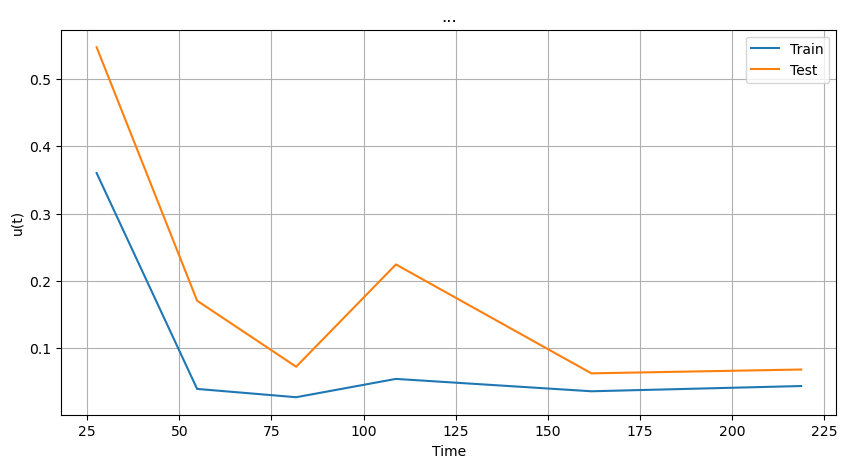

In [83]:
plt.figure(figsize=(10, 5))
plt.plot(time_elapsed, mae, label='Train')
plt.plot(time_elapsed, mae_test, label='Test')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.title("...")
plt.legend(loc ="upper right")
plt.grid(True)
plt.show()

In [91]:
results["jax_odeint_5"]["y_pred_test"]

Array([[ 0.00000000e+00,  1.00000000e+00],
       [ 4.71900920e-02,  9.99589097e-01],
       [ 9.44944637e-02,  9.94695451e-01],
       [ 1.41725380e-01,  9.85175224e-01],
       [ 1.88680609e-01,  9.70882835e-01],
       [ 2.35143755e-01,  9.51681379e-01],
       [ 2.80884810e-01,  9.27452415e-01],
       [ 3.25660696e-01,  8.98109703e-01],
       [ 3.69216320e-01,  8.63612281e-01],
       [ 4.11285973e-01,  8.23976478e-01],
       [ 4.51597378e-01,  7.79287803e-01],
       [ 4.89876204e-01,  7.29707552e-01],
       [ 5.25853899e-01,  6.75476308e-01],
       [ 5.59274688e-01,  6.16911508e-01],
       [ 5.89902639e-01,  5.54399574e-01],
       [ 6.17527311e-01,  4.88382140e-01],
       [ 6.41966532e-01,  4.19342326e-01],
       [ 6.63067709e-01,  3.47786376e-01],
       [ 6.80707360e-01,  2.74231018e-01],
       [ 6.94789454e-01,  1.99190432e-01],
       [ 7.05243883e-01,  1.23167710e-01],
       [ 7.12024822e-01,  4.66492501e-02],
       [ 7.15109828e-01, -2.98992866e-02],
       [ 7.

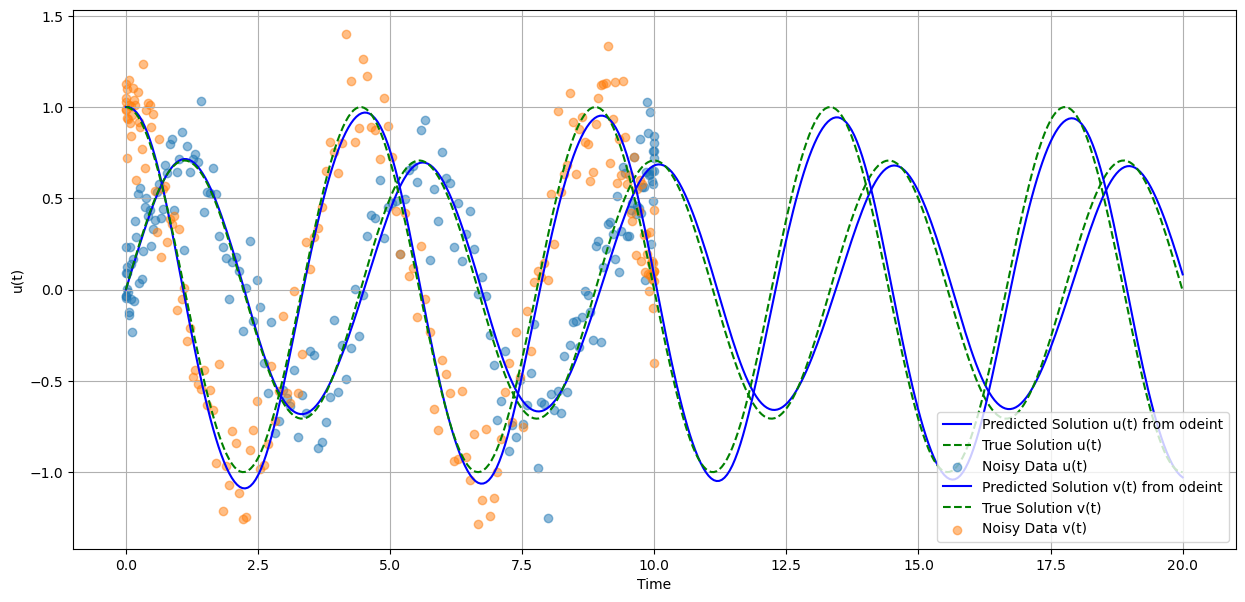

In [92]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
#plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t_test, results["jax_odeint_5"]["y_pred_test"].T[0], 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t_test, y_test.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

#plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t_test, results["jax_odeint_5"]["y_pred_test"].T[1], 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t_test, y_test.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

---

In [76]:
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

In [77]:
for i, max_iter in enumerate([100, 150, 200, 250, 500, 750, 1000]):
    layer_widths = [3, 10, 2]
    
    start_timer = time.time()
    ode_model = ODEOptimizationModel(y_noisy, t, D, layer_widths, penalty_lambda = 1000, max_iter = max_iter, y_init = estimated_solution)
    ode_model.build_model()
    ode_model.solve_model()
    end_timer = time.time()
    timer = end_timer - start_timer
    print(f"Time elapsed: {timer}")

    u_model, v_model = ode_model.extract_solution()

    def system_dynamics(y, t):
        u, v = y
        du_dt, dv_dt = ode_model.predict(t, u, v)
        return jnp.array([du_dt, dv_dt])

    initial_conditions = jnp.array([0.0, 1.0]) 
    y_pred_train = odeint(system_dynamics, initial_conditions, t)    
    
    mae_train = jnp.mean(jnp.abs(y_pred_train - y))
    
    y_pred_test = odeint(system_dynamics, initial_conditions, t_test)   
    mae_test = jnp.mean(jnp.abs(y_pred_test[200:] - y_test[200:]))
    
    results[f"pyomo_constr_{i}"] = {
        "mae":mae_train, "y_pred_train": y_pred_train, "time_elapsed": timer, "type": "pyomo_constr", 
        "max_iter": max_iter, "layer_widths": layer_widths, "penalty_lambda": 1000,
        "mae_test" : mae_test, "y_pred_test" : y_pred_test
        }

model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
Time elapsed: 13.157519102096558
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
Time elapsed: 22.17185688018799
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
Time elapsed: 55.58482098579407
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
Time elapsed: 96.21989703178406
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
Time elapsed: 121.83972191810608


In [78]:
# Using list comprehension for more concise and readable code
time_elapsed_pyomo = [result["time_elapsed"] for result in results.values() if result["type"] == "pyomo_constr"]
mae_pyomo = [result["mae"] for result in results.values() if result["type"] == "pyomo_constr"]
mae_test_pyomo = [result["mae_test"] for result in results.values() if result["type"] == "pyomo_constr"]

In [99]:
mae_test_pyomo

[Array(2.07526468, dtype=float64),
 Array(11.02529859, dtype=float64),
 Array(0.86207208, dtype=float64),
 Array(1.00758825, dtype=float64),
 Array(1.28201351, dtype=float64)]

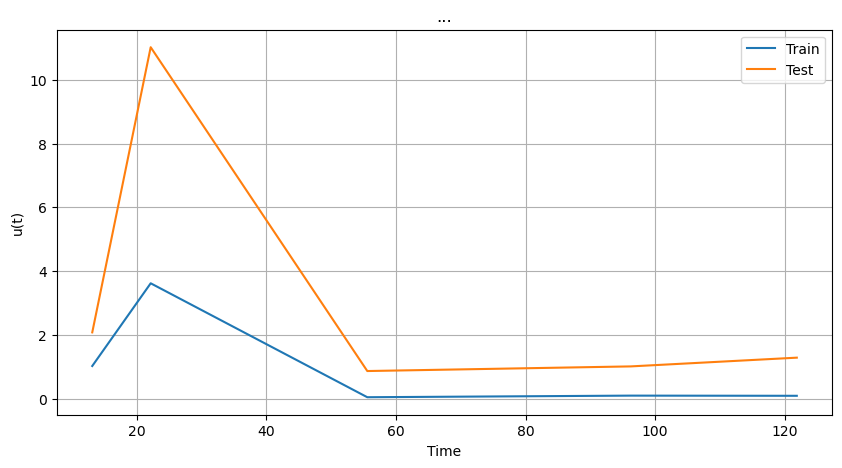

In [79]:
plt.figure(figsize=(10, 5))
plt.plot(time_elapsed_pyomo, mae_pyomo, label='Train')
plt.plot(time_elapsed_pyomo, mae_test_pyomo, label='Test')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.title("...")
plt.legend(loc ="upper right")
plt.grid(True)
plt.show()

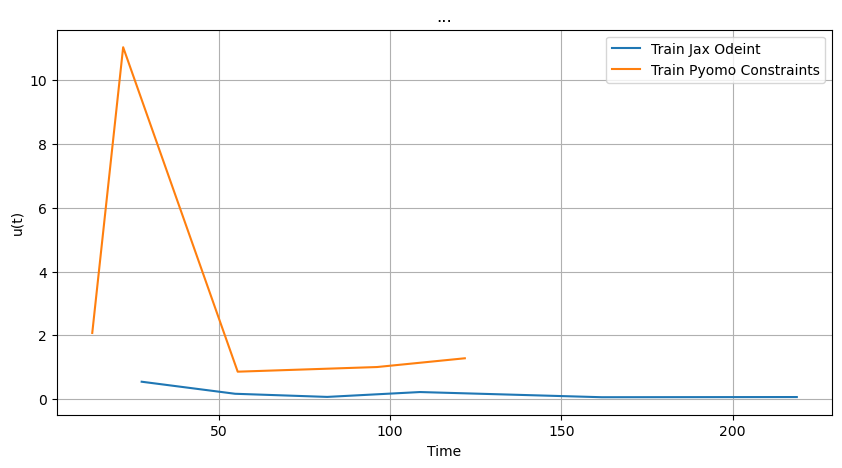

In [84]:
plt.figure(figsize=(10, 5))
plt.plot(time_elapsed, mae_test, label='Train Jax Odeint')
plt.plot(time_elapsed_pyomo, mae_test_pyomo, label='Train Pyomo Constraints')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.title("...")
plt.legend(loc ="upper right")
plt.grid(True)
plt.show()

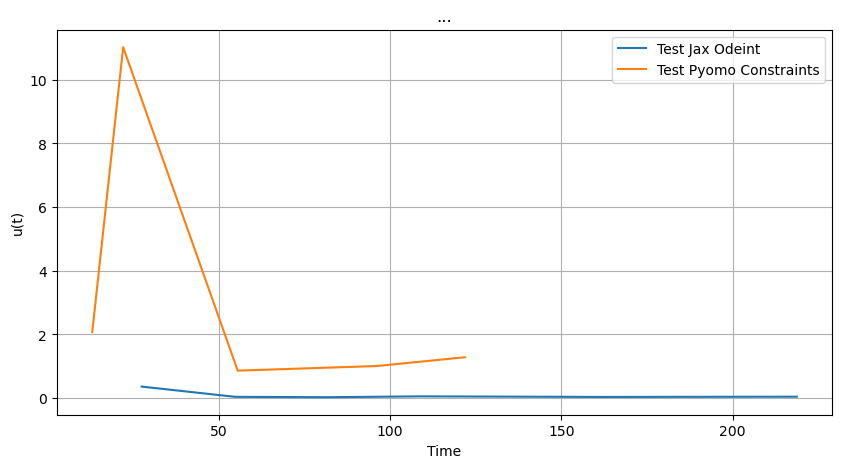

In [100]:
plt.figure(figsize=(10, 5))
plt.plot(time_elapsed, mae, label='Test Jax Odeint')
plt.plot(time_elapsed_pyomo, mae_test_pyomo, label='Test Pyomo Constraints')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.title("...")
plt.legend(loc ="upper right")
plt.grid(True)
plt.show()

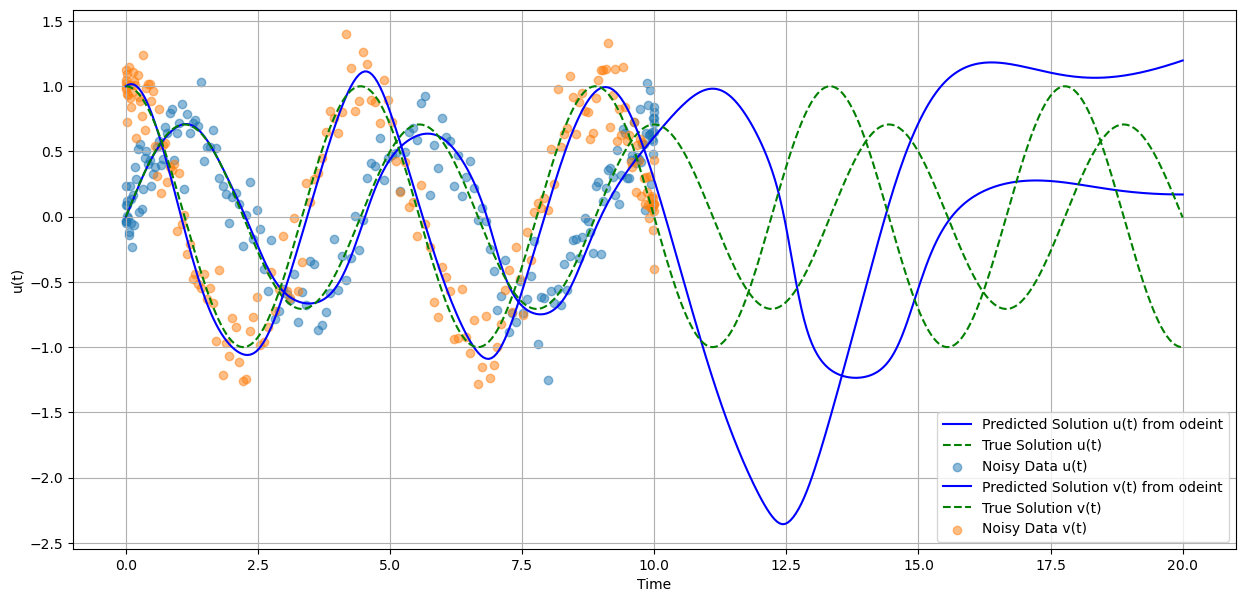

In [95]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
#plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t_test, results["pyomo_constr_3"]["y_pred_test"].T[0], 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t_test, y_test.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

#plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t_test, results["pyomo_constr_3"]["y_pred_test"].T[1], 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t_test, y_test.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

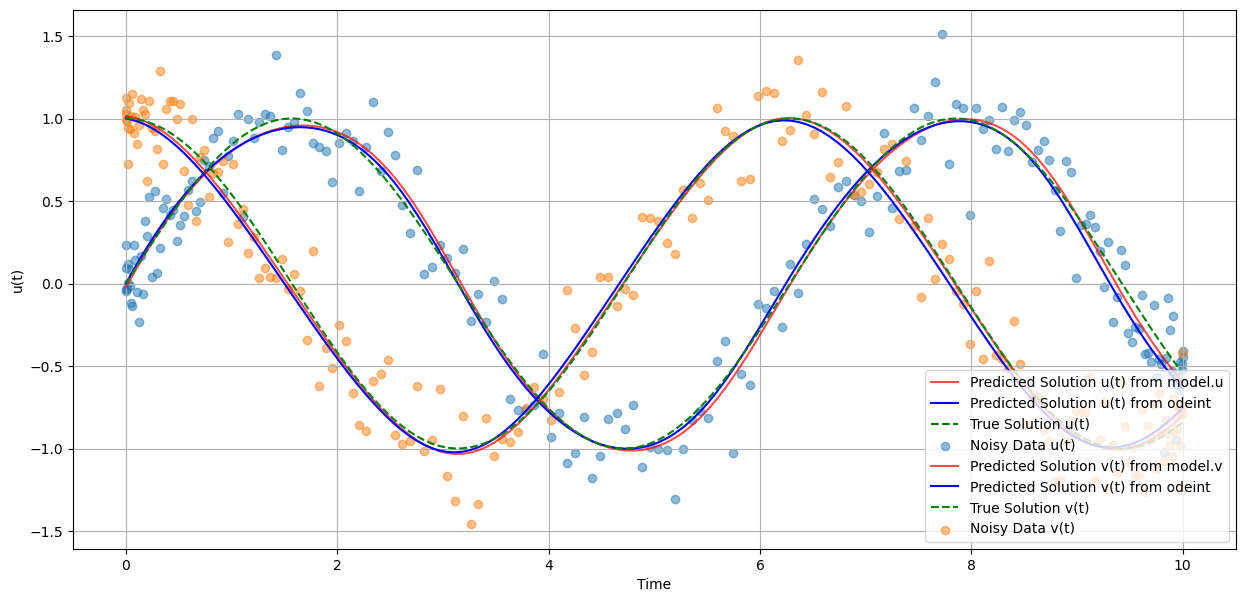

In [40]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t, u_odeint, 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t, v_odeint, 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t, y.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [47]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
start_time, end_time = 0, 20
N = 100 + (end_time - 10)*10
#--------------------------------------------GENERATE DATA--------------------------------------------#
spacing_type = "equally_spaced"
t, y, y_noisy_, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)
# numpy array is required for pyomo
t = np.array(jnp.squeeze(t))

solution = odeint(system_dynamics, initial_conditions, t)
u_odeint, v_odeint = solution[:, 0], solution[:, 1]

y_pred = jnp.vstack([u_odeint, v_odeint]).T

Abs Mean Error Train: 0.0351; Abs Mean Error Test: 0.5944


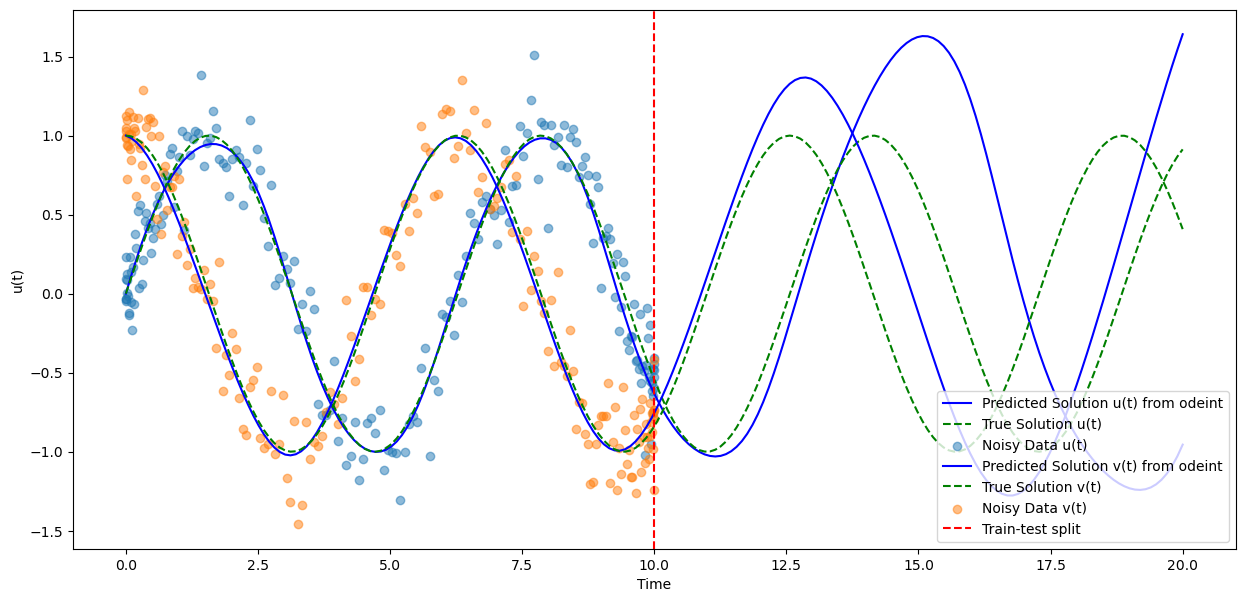

In [53]:
#-----------------------REGENERATE ORIGINAL DATA----------------------#
start_time, end_time = 0, 10
spacing_type = "chebyshev" 
t_original, _, y_noisy, _ = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

#----------------------------------MAE--------------------------------#
ame_train = jnp.mean(jnp.abs(y_pred[:100] - y[:100]))
ame_test = jnp.mean(jnp.abs(y_pred[100:] - y[100:]))
print(f'Abs Mean Error Train: {ame_train:.4f}; Abs Mean Error Test: {ame_test:.4f}')

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
# plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t, u_odeint, 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t_original, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

# plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t, v_odeint, 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t, y.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t_original, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
# plt.grid(True)
plt.show()